# 🎯 Tutorial 3: Uncertainty Quantification (UQ)

## Mastering Prediction Confidence in Protein Machine Learning

---

**Learning Objectives:**

By the end of this tutorial, you will be able to:
1. Assess and improve model calibration using temperature scaling
2. Implement heteroscedastic models to capture prediction uncertainty
3. Use MC dropout to estimate epistemic uncertainty
4. Apply conformal prediction for distribution-free uncertainty intervals
5. Distinguish between different types of uncertainty in your predictions

---

## 📦 Step 1: Environment Setup

### 1.1 Importing Libraries

Necessary packages include:
- **Transformers & Datasets**: For working with protein language models
- **Core ML Libraries**: scikit-learn for utilities, PyTorch for deep learning
- **Visualization**: matplotlib and seaborn for plotting
- **Data Processing**: pandas and numpy for data manipulation

In [1]:
# ============================================================
# CORE PYTHON LIBRARIES
# ============================================================
import os
import sys
import io
import zipfile
import logging
import time
import glob
import re
from pathlib import Path
from math import ceil

# ============================================================
# DATA HANDLING & PROCESSING
# ============================================================
import pandas as pd
import numpy as np
from datasets import load_dataset

# ============================================================
# MACHINE LEARNING & DEEP LEARNING
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# ============================================================
# SCIKIT-LEARN UTILITIES
# ============================================================
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, log_loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer

# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# STATISTICAL & SCIENTIFIC COMPUTING
# ============================================================
from scipy.special import softmax
from scipy.stats import spearmanr, pearsonr

# ============================================================
# UTILITIES
# ============================================================
import requests
from tqdm.auto import tqdm

print("✓ All libraries imported successfully!")

/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully!


## 📥 Step 2: Data Acquisition

### 2.1 About the CARE Dataset

We'll start with the [**CARE** benchmarking dataset](https://github.com/jsunn-y/CARE/), which includes protein sequences annotated with their EC (Enzyme Commission) numbers.

**What are EC Numbers?**
- EC numbers classify enzymes based on the reactions they catalyze
- Hierarchical system with multiple levels of specificity
- Examples:
  - **EC1**: Oxidoreductases
  - **EC2**: Transferases
  - **EC 2.3.1**: Acyltransferases (transferring groups other than amino-acyl groups)

### 2.2 Downloading CARE Dataset

We'll download the processed CARE datasets from Zenodo if not already available locally.

In [4]:
# ============================================================
# CONFIGURE DATA PATHS
# ============================================================
DATA_DIR = Path("data/care")
DATA_DIR.mkdir(parents=True, exist_ok=True)

ZIP_PATH = DATA_DIR / "datasets.zip"
ZENODO_URL = "https://zenodo.org/record/12195378/files/datasets.zip?download=1"

# ============================================================
# DOWNLOAD CARE DATASET FROM ZENODO
# ============================================================
if not ZIP_PATH.exists():
    print("📥 Downloading CARE processed datasets from Zenodo...")
    print("⏳ This may take a minute...")
    
    with requests.get(ZENODO_URL, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        
        with open(ZIP_PATH, "wb") as f, tqdm(total=total, unit='B', unit_scale=True, desc="CARE zip") as pbar:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    print("✓ Download complete!")
else:
    print(f"✓ Found existing CARE zip at {ZIP_PATH}")

# ============================================================
# EXTRACT DATASET
# ============================================================
if not (DATA_DIR / "datasets").is_dir():
    print("📂 Extracting CARE datasets...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(DATA_DIR)
    print(f"✓ Extracted CARE datasets to {DATA_DIR}")
else:
    print("✓ CARE datasets already extracted")

print("\n" + "="*60)
print("Dataset download and extraction complete!")
print("="*60)

📥 Downloading CARE processed datasets from Zenodo...
⏳ This may take a minute...


CARE zip: 100%|██████████| 99.4M/99.4M [03:15<00:00, 509kB/s] 


✓ Download complete!
📂 Extracting CARE datasets...
✓ Extracted CARE datasets to data/care

Dataset download and extraction complete!


## 📊 Step 3: Data Loading and Preparation

### 3.1 Loading Train and Test Datasets

We'll load the CARE protein datasets and prepare them for classification tasks.

In [5]:
# ============================================================
# LOAD TRAINING DATA
# ============================================================
train_file = DATA_DIR / "datasets/splits/task1/protein_train.csv" 
train_df = pd.read_csv(train_file, index_col=0)

print("✓ Loaded train dataframe")
print(f"  Shape: {train_df.shape}")
print(f"\n📋 First few rows:")
print(train_df.head())

# ============================================================
# LOAD TEST DATA (MULTIPLE SPLITS)
# ============================================================
test_file_1 = DATA_DIR / "datasets/splits/task1/30-50_protein_test.csv" 
test_file_2 = DATA_DIR / "datasets/splits/task1/30_protein_test.csv" 
test_file_3 = DATA_DIR / "datasets/splits/task1/50-70_protein_test.csv" 

# Concatenate all test splits
test_df = pd.concat([
    pd.read_csv(test_file_1),
    pd.read_csv(test_file_2),
    pd.read_csv(test_file_3)
])

print(f"\n✓ Loaded test dataframe")
print(f"  Shape: {test_df.shape}")
print(f"\n📋 First few rows:")
print(test_df.head())

✓ Loaded train dataframe
  Shape: (168682, 13)

📋 First few rows:
        Entry   Entry Name                                           Sequence  \
0  A0A009IHW8  ABTIR_ACIB9  MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...   
1  A0A024SC78  CUTI1_HYPJR  MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...   
2  A0A024SH76   GUX2_HYPJR  MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...   
3  A0A059TC02   CCR1_PETHY  MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...   
4  A0A067XGX8  AROG2_PETHY  MALTATATTRGGSALPNSCLQTPKFQSLQKPTFISSFPTNKKTKPR...   

  EC number  Length            EC All clusterRes50 clusterRes30 clusterRes70  \
0   3.2.2.6     269  3.2.2.-; 3.2.2.6   A0A009IHW8       A1AY86   A0A009IHW8   
1  3.1.1.74     248          3.1.1.74       A8QPD8       A8QPD8       A8QPD8   
2  3.2.1.91     471          3.2.1.91       B2ABX7       B2AE04   A0A024SH76   
3  1.2.1.44     333          1.2.1.44       Q6K9A2       Q5FB34       Q9S9N9   
4  2.5.1.54     512          2.5.1.54       P80

### 3.2 Preparing Classification Dataset

We'll prepare the data for multi-class classification by:
1. Selecting top EC1 classes (top level of EC hierarchy)
2. Filtering datasets to include only these classes
3. Creating label mappings
4. Splitting into train/val/test/calibration sets

In [6]:
# ============================================================
# CONFIGURE DATASET PARAMETERS
# ============================================================
seq_col = "Sequence"
LABEL_COL = "EC1"  # Top level of EC hierarchy only
TOP_N = 10  # Number of top classes to keep (will include all 7 EC1 classes)

# ============================================================
# STEP 1: SELECT TOP N CLASSES
# ============================================================
label_counts = train_df[LABEL_COL].value_counts()
valid_labels = label_counts.nlargest(TOP_N).index.tolist()

print(f"📊 Selected top {len(valid_labels)} EC1 classes:")
for i, label in enumerate(valid_labels, 1):
    count = label_counts[label]
    print(f"   {i}. EC{label}: {count} samples")

# ============================================================
# STEP 2: FILTER AND MAP LABELS FOR TRAINING DATA
# ============================================================
train_df = train_df[train_df[LABEL_COL].isin(valid_labels)].copy()

# Create label mappings
label_to_id = {l: i for i, l in enumerate(valid_labels)}
id_to_label = {i: l for l, i in label_to_id.items()}

# Add integer label IDs
train_df['label_id'] = train_df[LABEL_COL].map(label_to_id)

print(f"\n✓ Filtered training data: {train_df.shape[0]} samples")

# ============================================================
# STEP 3: FILTER AND MAP LABELS FOR TEST DATA
# ============================================================
test_df = test_df[test_df[LABEL_COL].isin(valid_labels)].copy()
test_df['label_id'] = test_df[LABEL_COL].map(label_to_id)

print(f"✓ Filtered test data: {test_df.shape[0]} samples")

# ============================================================
# STEP 4: CREATE TRAIN/VAL/TEST/CALIBRATION SPLITS
# ============================================================
# Split training data into train and validation (stratified)
train_df, val_df = train_test_split(
    train_df, 
    test_size=0.2, 
    stratify=train_df['label_id'], 
    random_state=4242
)

# Split test data into test and calibration sets (stratified)
test_df, test_cal_df = train_test_split(
    test_df, 
    test_size=0.2, 
    stratify=test_df['label_id'], 
    random_state=4224
)

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("Dataset Split Summary:")
print("="*60)
print(f"  Train:       {train_df.shape[0]:>6} samples")
print(f"  Validation:  {val_df.shape[0]:>6} samples")
print(f"  Test:        {test_df.shape[0]:>6} samples")
print(f"  Calibration: {test_cal_df.shape[0]:>6} samples")
print(f"  Num Classes: {len(valid_labels):>6}")
print("="*60)

📊 Selected top 7 EC1 classes:
   1. EC2: 61427 samples
   2. EC3: 29803 samples
   3. EC1: 22531 samples
   4. EC4: 19465 samples
   5. EC6: 17875 samples
   6. EC5: 11959 samples
   7. EC7: 5622 samples

✓ Filtered training data: 168682 samples
✓ Filtered test data: 575 samples

Dataset Split Summary:
  Train:       134945 samples
  Validation:   33737 samples
  Test:           460 samples
  Calibration:    115 samples
  Num Classes:      7


## 🤖 Step 4: Model Setup and Embedding Extraction

### 4.1 Loading ESM Protein Language Model

We'll use embeddings from the frozen ESM2 base model as features for our classifier. ESM2 is a state-of-the-art protein language model trained on millions of protein sequences.

**Architecture Overview:**
- **Base Model**: ESM2 (facebook/esm2_t6_8M_UR50D)
- **Embedding Strategy**: Extract CLS token embeddings
- **Model State**: Frozen (no fine-tuning)
- **Precision**: Half precision (float16) for efficiency

In [7]:
# ============================================================
# CONFIGURE COMPUTE BACKEND
# ============================================================
def get_backend():
    """
    Detect and return the available compute backend.
    Returns: (device, backend_name, n_gpus)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backend = "cuda" if torch.cuda.is_available() else "cpu"
    n_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0
    return device, backend, n_gpus

DEVICE, BACKEND, N_GPUS = get_backend()

print("🖥️  Compute Configuration:")
print(f"   Device:  {DEVICE}")
print(f"   Backend: {BACKEND}")
print(f"   GPUs:    {N_GPUS}")

# ============================================================
# LOAD ESM2 MODEL AND TOKENIZER
# ============================================================
MODEL_NAME = "facebook/esm2_t6_8M_UR50D"  # 8M parameter model
# Alternative options:
# MODEL_NAME = "facebook/esm2_t12_35M_UR50D"  # 35M parameters
# MODEL_NAME = "facebook/esm2_t33_650M_UR50D"  # 650M parameters

print(f"\n🧬 Loading ESM2 model: {MODEL_NAME}")
print("   Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, model_max_length=1500, truncation=True)
print("   ✓ Tokenizer loaded")

print("   Loading model...")
esm_model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
print("   ✓ Model loaded")

# ============================================================
# CONFIGURE MODEL FOR EMBEDDING EXTRACTION
# ============================================================
print("\n⚙️  Configuring model:")

# Set to evaluation mode
esm_model.eval()
print("   ✓ Set to evaluation mode")

# Convert to half precision for efficiency
esm_model.half()
print("   ✓ Converted to half precision (float16)")

# Freeze all parameters (no training)
for p in esm_model.parameters():
    p.requires_grad = False
print("   ✓ Frozen all parameters")

print("\n✓ ESM2 model ready for embedding extraction!")

🖥️  Compute Configuration:
   Device:  cuda
   Backend: cuda
   GPUs:    1

🧬 Loading ESM2 model: facebook/esm2_t6_8M_UR50D
   Loading tokenizer...
   ✓ Tokenizer loaded
   Loading model...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ✓ Model loaded

⚙️  Configuring model:
   ✓ Set to evaluation mode
   ✓ Converted to half precision (float16)
   ✓ Frozen all parameters

✓ ESM2 model ready for embedding extraction!


### 4.2 Defining Embedding Extraction Functions

We'll create utility functions to efficiently extract protein sequence embeddings in batches.

In [8]:
# ============================================================
# EMBEDDING EXTRACTION FUNCTION
# ============================================================
def get_esm_embeddings(seqs, model, tokenizer, device, max_batch=256):
    """
    Extract ESM embeddings for a list of protein sequences.
    
    Parameters:
    -----------
    seqs : list of str
        Protein sequences to embed
    model : AutoModel
        Pre-loaded ESM model
    tokenizer : AutoTokenizer
        Pre-loaded ESM tokenizer
    device : torch.device
        Device to run on (CPU/GPU)
    max_batch : int
        Maximum batch size for processing
        
    Returns:
    --------
    numpy.ndarray
        Array of embeddings, shape (n_sequences, embedding_dim)
    """
    embs = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(seqs), max_batch), desc="Extracting embeddings"):
            # Get batch of sequences
            batch = seqs[i:i+max_batch]
            
            # Tokenize sequences
            toks = tokenizer(
                batch, 
                return_tensors="pt", 
                padding=True, 
                truncation=True, 
                add_special_tokens=True
            )
            
            # Move to device
            toks = {k: v.to(device) for k, v in toks.items()}
            
            # Extract embeddings
            out = model(**toks, return_dict=True)
            
            # Get CLS token embeddings (first token)
            cls_emb = out.last_hidden_state[:, 0, :]
            
            # Store on CPU
            embs.append(cls_emb.cpu())
    
    # Concatenate all batches
    return torch.cat(embs, dim=0).numpy()


# ============================================================
# HELPER FUNCTION: MAINTAIN ORIGINAL ORDER
# ============================================================
def embed_sequences_in_original_order(seqs, model, tokenizer, device, **kwargs):
    """
    Extract embeddings while maintaining original sequence order.
    Sequences are sorted by length for efficiency, then unsorted.
    
    Parameters:
    -----------
    seqs : list of str
        Protein sequences to embed
    model, tokenizer, device : 
        Model components
    **kwargs : 
        Additional arguments for get_esm_embeddings
        
    Returns:
    --------
    numpy.ndarray
        Embeddings in original sequence order
    """
    # Track original indices
    indexed = list(enumerate(seqs))
    
    # Sort by sequence length for efficiency
    indexed_sorted = sorted(indexed, key=lambda x: len(x[1]))
    sorted_indices, sorted_seqs = zip(*indexed_sorted)
    
    # Get embeddings in sorted order
    sorted_embs = get_esm_embeddings(sorted_seqs, model, tokenizer, device, **kwargs)
    
    # Unsort to original order
    sorted_indices = np.array(sorted_indices)
    reverse_idx = np.argsort(sorted_indices)
    
    return sorted_embs[reverse_idx]

print("✓ Embedding extraction functions defined")

✓ Embedding extraction functions defined


### 4.3 Extracting Sequence Embeddings

Now we'll extract embeddings for all protein sequences in our train, validation, test, and calibration sets. This process may take a few minutes depending on your hardware.

In [9]:
# ============================================================
# EXTRACT TRAINING SET EMBEDDINGS
# ============================================================
print("🔄 Extracting train embeddings...")
X_train = embed_sequences_in_original_order(
    train_df[seq_col].tolist(), 
    esm_model, 
    tokenizer, 
    DEVICE
)
y_train = train_df['label_id'].values
print(f"   ✓ Train embeddings: {X_train.shape}")

# ============================================================
# EXTRACT VALIDATION SET EMBEDDINGS
# ============================================================
print("\n🔄 Extracting validation embeddings...")
X_val = embed_sequences_in_original_order(
    val_df[seq_col].tolist(), 
    esm_model, 
    tokenizer, 
    DEVICE
)
y_val = val_df['label_id'].values
print(f"   ✓ Val embeddings: {X_val.shape}")

# ============================================================
# EXTRACT TEST SET EMBEDDINGS
# ============================================================
print("\n🔄 Extracting test embeddings...")
X_test = embed_sequences_in_original_order(
    test_df[seq_col].tolist(), 
    esm_model, 
    tokenizer, 
    DEVICE
)
y_test = test_df['label_id'].values
print(f"   ✓ Test embeddings: {X_test.shape}")

# ============================================================
# EXTRACT CALIBRATION SET EMBEDDINGS
# ============================================================
print("\n🔄 Extracting calibration embeddings...")
X_test_cal = embed_sequences_in_original_order(
    test_cal_df[seq_col].tolist(), 
    esm_model, 
    tokenizer, 
    DEVICE
)
y_test_cal = test_cal_df['label_id'].values
print(f"   ✓ Calibration embeddings: {X_test_cal.shape}")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("Embedding Extraction Complete!")
print("="*60)
print(f"  Train:       {X_train.shape}")
print(f"  Validation:  {X_val.shape}")
print(f"  Test:        {X_test.shape}")
print(f"  Calibration: {X_test_cal.shape}")
print(f"  Embedding dimension: {X_train.shape[1]}")
print("="*60)

🔄 Extracting train embeddings...


Extracting embeddings: 100%|██████████| 528/528 [02:11<00:00,  4.02it/s]


   ✓ Train embeddings: (134945, 320)

🔄 Extracting validation embeddings...


Extracting embeddings: 100%|██████████| 132/132 [00:30<00:00,  4.30it/s]


   ✓ Val embeddings: (33737, 320)

🔄 Extracting test embeddings...


Extracting embeddings: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


   ✓ Test embeddings: (460, 320)

🔄 Extracting calibration embeddings...


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

   ✓ Calibration embeddings: (115, 320)

Embedding Extraction Complete!
  Train:       (134945, 320)
  Validation:  (33737, 320)
  Test:        (460, 320)
  Calibration: (115, 320)
  Embedding dimension: 320


## 🎯 Step 5: Building an MLP Classifier

### 5.1 Defining the Model Architecture

We'll create a simple Multi-Layer Perceptron (MLP) classifier on top of the frozen ESM embeddings. This classifier will predict EC numbers from the protein embeddings.

**Architecture:**
- Input layer: ESM embedding dimension
- Hidden layer: 128 units with ReLU activation
- Dropout: 0.01 for regularization
- Output layer: Number of EC classes

In [10]:
# ============================================================
# DEFINE MLP CLASSIFIER ARCHITECTURE
# ============================================================
class MLPClassifier(nn.Module):
    """
    Simple MLP classifier for EC number prediction.
    
    Architecture:
    - Linear layer: in_dim -> hidden_dim
    - ReLU activation
    - Dropout for regularization
    - Linear layer: hidden_dim -> num_classes
    """
    def __init__(self, in_dim, num_classes, hidden_dim=128, dropout=0.01):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)

# ============================================================
# INITIALIZE MODEL
# ============================================================
num_classes = len(valid_labels)
in_dim = X_train.shape[1]

model_clf = MLPClassifier(in_dim, num_classes).to(DEVICE)

print("🏗️  Model Architecture:")
print(f"   Input dimension:  {in_dim}")
print(f"   Hidden dimension: 128")
print(f"   Output classes:   {num_classes}")
print(f"   Dropout rate:     0.01")
print(f"\n✓ Model initialized on {DEVICE}")

🏗️  Model Architecture:
   Input dimension:  320
   Hidden dimension: 128
   Output classes:   7
   Dropout rate:     0.01

✓ Model initialized on cuda


### 5.2 Configuring Training Setup

We'll set up class weights to handle imbalanced data, configure the optimizer and loss function, and prepare data tensors.

In [11]:
# ============================================================
# COMPUTE CLASS WEIGHTS (FOR IMBALANCED DATA)
# ============================================================
print("⚖️  Computing class weights for balanced training...")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("   ✓ Class weights computed")

# ============================================================
# CONFIGURE OPTIMIZER AND LOSS
# ============================================================
optimizer = torch.optim.Adam(model_clf.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("\n⚙️  Training Configuration:")
print(f"   Optimizer:    Adam (lr=0.01)")
print(f"   Loss:         CrossEntropyLoss (weighted)")
print(f"   Epochs:       500")

# ============================================================
# PREPARE DATA TENSORS
# ============================================================
print("\n🔄 Converting data to PyTorch tensors...")

# Training data
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(DEVICE)

# Validation data
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(DEVICE)

# Test data
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

# Calibration data
X_test_cal_t = torch.tensor(X_test_cal, dtype=torch.float32).to(DEVICE)
y_test_cal_t = torch.tensor(y_test_cal, dtype=torch.long).to(DEVICE)

print("   ✓ All data tensors prepared and moved to device")
print("\n✓ Ready to start training!")

⚖️  Computing class weights for balanced training...
   ✓ Class weights computed

⚙️  Training Configuration:
   Optimizer:    Adam (lr=0.01)
   Loss:         CrossEntropyLoss (weighted)
   Epochs:       500

🔄 Converting data to PyTorch tensors...
   ✓ All data tensors prepared and moved to device

✓ Ready to start training!


### 5.3 Training the Classifier

Now we'll train the model for 500 epochs, monitoring both training and validation performance.

In [12]:
# ============================================================
# TRAINING LOOP
# ============================================================
print("🚀 Starting training...\n")

num_epochs = 500
for epoch in range(num_epochs):
    # --------------------------------------------------------
    # TRAINING PHASE
    # --------------------------------------------------------
    model_clf.train()
    optimizer.zero_grad()
    
    # Forward pass
    logits = model_clf(X_train_t)
    loss = criterion(logits, y_train_t)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # --------------------------------------------------------
    # VALIDATION PHASE
    # --------------------------------------------------------
    model_clf.eval()
    with torch.no_grad():
        val_logits = model_clf(X_val_t)
        val_loss = criterion(val_logits, y_val_t)
        val_preds = torch.argmax(val_logits, dim=1)
        val_acc = (val_preds == y_val_t).float().mean()
    
    # --------------------------------------------------------
    # LOGGING (every 50 epochs)
    # --------------------------------------------------------
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:03d} | "
              f"train_loss={loss.item():.4f} | "
              f"val_loss={val_loss.item():.4f} | "
              f"val_acc={val_acc.item():.4f}")

print("\n✓ Training complete!")

🚀 Starting training...

Epoch 050 | train_loss=1.1287 | val_loss=1.1296 | val_acc=0.5261
Epoch 100 | train_loss=0.9288 | val_loss=0.9249 | val_acc=0.6204
Epoch 150 | train_loss=0.9214 | val_loss=0.8707 | val_acc=0.6706
Epoch 200 | train_loss=0.7719 | val_loss=0.7837 | val_acc=0.6824
Epoch 250 | train_loss=0.7211 | val_loss=0.7394 | val_acc=0.7172
Epoch 300 | train_loss=0.6767 | val_loss=0.6918 | val_acc=0.7210
Epoch 350 | train_loss=0.7776 | val_loss=0.7222 | val_acc=0.6895
Epoch 400 | train_loss=0.6241 | val_loss=0.6421 | val_acc=0.7418
Epoch 450 | train_loss=0.5999 | val_loss=0.6197 | val_acc=0.7539
Epoch 500 | train_loss=0.5779 | val_loss=0.5993 | val_acc=0.7620

✓ Training complete!


## 📊 Step 6: Model Evaluation and Calibration Analysis

### 6.1 Evaluating Test Set Performance

Now we'll evaluate our trained classifier on the test set and analyze the probability distributions.

In [13]:
# ============================================================
# EVALUATE ON TEST SET
# ============================================================
print("📊 Evaluating model on test set...\n")

model_clf.eval()

# Get predictions for test set
with torch.no_grad():
    logits_test = model_clf(X_test_t).cpu().numpy()
    probs_test = softmax(logits_test, axis=1)

# Get predictions for validation set
with torch.no_grad():
    logits_val = model_clf(X_val_t).cpu().numpy()
    probs_val = softmax(logits_val, axis=1)

# Get predictions for calibration set
with torch.no_grad():
    logits_cal = model_clf(X_test_cal_t).cpu().numpy()
    probs_cal = softmax(logits_cal, axis=1)

# ============================================================
# COMPUTE OVERALL METRICS
# ============================================================
y_pred = probs_test.argmax(1)
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, probs_test)

print("="*60)
print("Overall Test Performance:")
print("="*60)
print(f"  Accuracy:  {acc:.3f}")
print(f"  Log Loss:  {ll:.3f}")
print("="*60)

# ============================================================
# PER-CLASS ACCURACY
# ============================================================
print("\n📋 Per-Class Performance:")
print("-"*60)

classes = np.unique(y_test)
for c in sorted(classes):
    mask = y_test == c
    class_acc = (y_pred[mask] == y_test[mask]).mean()
    print(f"  EC{id_to_label[c]} (label {c}): "
          f"accuracy = {class_acc:.3f} "
          f"(n={mask.sum():>4})")

print("-"*60)

# ============================================================
# COMPUTE PREDICTIVE ENTROPY
# ============================================================
def entropy(p):
    """
    Calculate predictive entropy for probability distributions.
    
    Parameters:
    -----------
    p : numpy.ndarray
        Probability distributions, shape (n_samples, n_classes)
        
    Returns:
    --------
    numpy.ndarray
        Entropy values for each sample
    """
    p = np.clip(p, 1e-9, 1)
    return -(p * np.log(p)).sum(axis=1)

entropies = entropy(probs_test)

print(f"\n✓ Computed predictive entropy")
print(f"   Mean entropy: {entropies.mean():.3f}")
print(f"   Std entropy:  {entropies.std():.3f}")

📊 Evaluating model on test set...

Overall Test Performance:
  Accuracy:  0.550
  Log Loss:  1.373

📋 Per-Class Performance:
------------------------------------------------------------
  EC2 (label 0): accuracy = 0.480 (n=  75)
  EC3 (label 1): accuracy = 0.600 (n=  95)
  EC1 (label 2): accuracy = 0.541 (n= 170)
  EC4 (label 3): accuracy = 0.432 (n=  37)
  EC6 (label 4): accuracy = 0.652 (n=  23)
  EC5 (label 5): accuracy = 0.500 (n=  38)
  EC7 (label 6): accuracy = 0.818 (n=  22)
------------------------------------------------------------

✓ Computed predictive entropy
   Mean entropy: 0.923
   Std entropy:  0.515


### 6.2 Analyzing Calibration

We'll examine the relationship between model confidence and actual accuracy by plotting calibration curves.

📈 Creating calibration plots...



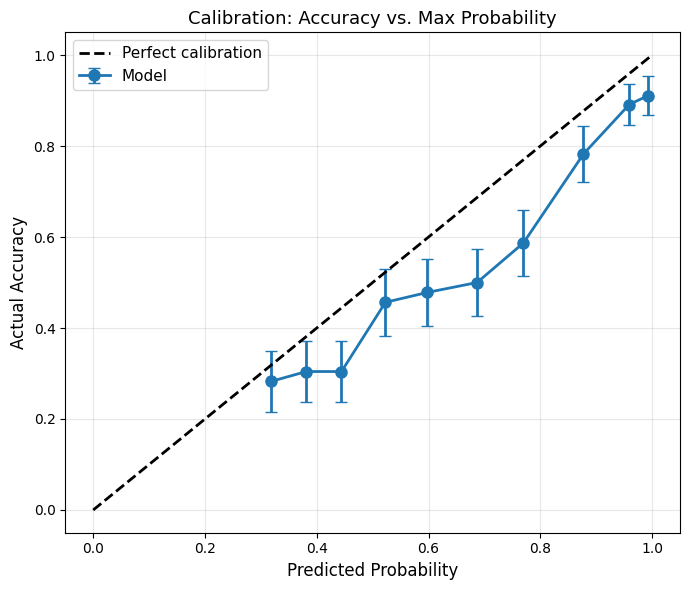

✓ Plot 1: Accuracy vs. Max Probability


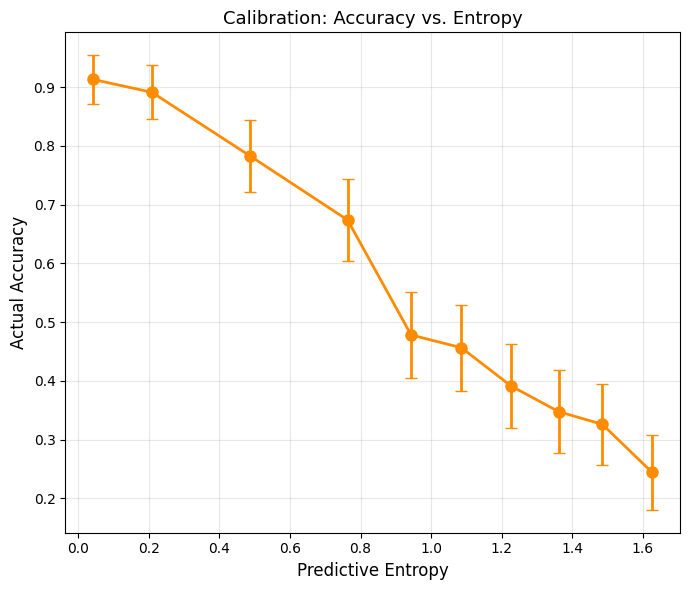

✓ Plot 2: Accuracy vs. Entropy

💡 Interpretation:
   - Higher entropy indicates more uncertainty
   - Lower accuracy at high entropy suggests good uncertainty estimation


In [14]:
# ============================================================
# PLOT 1: ACCURACY VS. MAX PROBABILITY
# ============================================================
print("📈 Creating calibration plots...\n")

max_prob = probs_test.max(axis=1)
bins_prob = np.quantile(max_prob, np.linspace(0, 1, 11))

# Compute binned statistics
bin_acc_prob = []
bin_centers_prob = []
bin_errs = []

for i in range(len(bins_prob) - 1):
    mask = (max_prob >= bins_prob[i]) & (max_prob < bins_prob[i+1])
    if mask.sum() > 0:
        # Accuracy in this bin
        bin_acc_prob.append((y_test[mask] == probs_test[mask].argmax(1)).mean())
        # Average probability in this bin
        bin_centers_prob.append(max_prob[mask].mean())
        # Standard error
        bin_errs.append(np.std(y_test[mask] == probs_test[mask].argmax(1)) / np.sqrt(mask.sum()))

# Plot
plt.figure(figsize=(7, 6))
plt.errorbar(bin_centers_prob, bin_acc_prob, yerr=bin_errs, 
             fmt='o-', capsize=4, label='Model', linewidth=2, markersize=8)
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2)
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Actual Accuracy", fontsize=12)
plt.title("Calibration: Accuracy vs. Max Probability", fontsize=13)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Plot 1: Accuracy vs. Max Probability")

# ============================================================
# PLOT 2: ACCURACY VS. ENTROPY
# ============================================================
bins_entropy = np.quantile(entropies, np.linspace(0, 1, 11))

# Compute binned statistics
bin_acc = []
bin_centers = []
bin_errs = []

for i in range(len(bins_entropy) - 1):
    mask = (entropies >= bins_entropy[i]) & (entropies < bins_entropy[i+1])
    if mask.sum() > 0:
        # Accuracy in this bin
        bin_acc.append((y_test[mask] == probs_test[mask].argmax(1)).mean())
        # Average entropy in this bin
        bin_centers.append(entropies[mask].mean())
        # Standard error
        bin_errs.append(np.std(y_test[mask] == probs_test[mask].argmax(1)) / np.sqrt(mask.sum()))

# Plot
plt.figure(figsize=(7, 6))
plt.errorbar(bin_centers, bin_acc, yerr=bin_errs, 
             fmt='o-', capsize=4, linewidth=2, markersize=8, color='darkorange')
plt.xlabel("Predictive Entropy", fontsize=12)
plt.ylabel("Actual Accuracy", fontsize=12)
plt.title("Calibration: Accuracy vs. Entropy", fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Plot 2: Accuracy vs. Entropy")
print("\n💡 Interpretation:")
print("   - Higher entropy indicates more uncertainty")
print("   - Lower accuracy at high entropy suggests good uncertainty estimation")

## 🌡️ Step 7: Temperature Scaling for Calibration

### 7.1 Implementing Temperature Scaling

**Temperature Scaling** is a simple yet effective post-processing technique to improve model calibration. It learns a single scalar parameter (temperature) that rescales the logits before applying softmax.

**How it works:**
- Original probabilities: `softmax(logits)`
- Scaled probabilities: `softmax(logits / T)` where T is the temperature
- T > 1: Makes predictions more uncertain (flatter distribution)
- T < 1: Makes predictions more confident (sharper distribution)

In [15]:
# ============================================================
# DEFINE TEMPERATURE SCALER
# ============================================================
class TemperatureScaler(nn.Module):
    """
    Temperature scaling module for calibration.
    Learns a single temperature parameter to rescale logits.
    """
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, logits):
        return logits / self.temperature

# ============================================================
# TEMPERATURE FITTING FUNCTION
# ============================================================
def fit_temperature(logits, labels):
    """
    Fit optimal temperature on a calibration set.
    
    Parameters:
    -----------
    logits : numpy.ndarray
        Model logits on calibration set
    labels : numpy.ndarray
        True labels
        
    Returns:
    --------
    TemperatureScaler
        Fitted temperature scaler
    """
    model = TemperatureScaler()
    optimizer = torch.optim.LBFGS([model.temperature], lr=0.01, max_iter=500)
    
    # Convert to tensors
    logits_t = torch.tensor(logits, dtype=torch.float32)
    labels_t = torch.tensor(labels, dtype=torch.long)
    criterion = nn.CrossEntropyLoss()
    
    # Optimization closure
    def closure():
        optimizer.zero_grad()
        loss = criterion(model(logits_t), labels_t)
        loss.backward()
        return loss
    
    # Optimize
    optimizer.step(closure)
    
    return model

# ============================================================
# FIT TEMPERATURE ON CALIBRATION SET
# ============================================================
print("🌡️  Fitting temperature scaler...\n")

scaler = fit_temperature(logits_cal, y_test_cal)

# Apply temperature scaling to test logits
scaled_logits = scaler(torch.tensor(logits_test, dtype=torch.float32)).detach().numpy()
scaled_probs = softmax(scaled_logits, axis=1)

print(f"✓ Temperature fitted: T = {scaler.temperature.item():.4f}")
print(f"\n💡 Interpretation:")
if scaler.temperature.item() > 1:
    print(f"   T > 1: Model is overconfident, temperature makes it more uncertain")
elif scaler.temperature.item() < 1:
    print(f"   T < 1: Model is underconfident, temperature makes it more confident")
else:
    print(f"   T ≈ 1: Model is well-calibrated")

🌡️  Fitting temperature scaler...

✓ Temperature fitted: T = 1.7237

💡 Interpretation:
   T > 1: Model is overconfident, temperature makes it more uncertain


### 7.2 Reliability Diagrams

We'll create reliability diagrams to visualize calibration before and after temperature scaling. A perfectly calibrated model should align with the diagonal.


📊 Computing reliability diagrams...

Calibration Metrics:
  Temperature:           1.7237
  ECE (pre-scaling):     0.1051
  ECE (post-scaling):    0.0606
  Improvement:           42.4%


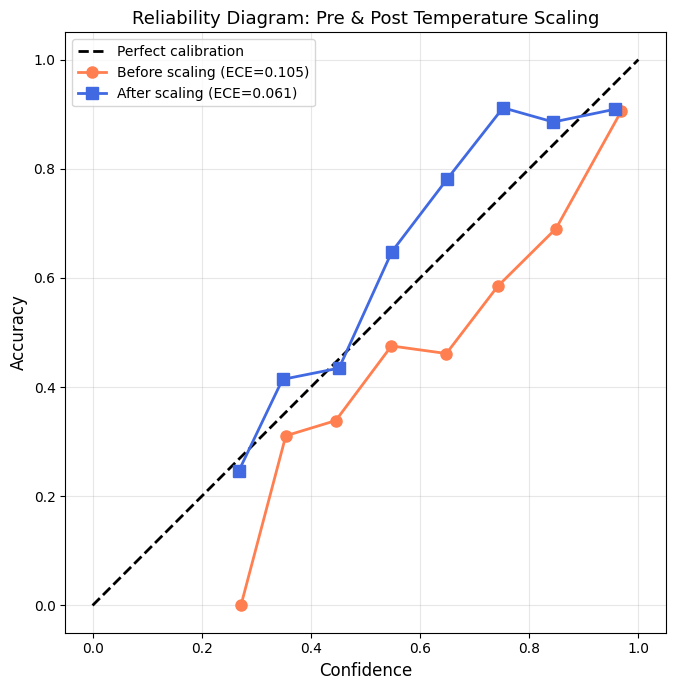


✓ Temperature scaling improves calibration!


In [16]:
# ============================================================
# RELIABILITY DIAGRAM FUNCTION
# ============================================================
def reliability_diagram(probs, y_true, n_bins=10):
    """
    Compute reliability diagram statistics and ECE (Expected Calibration Error).
    
    Parameters:
    -----------
    probs : numpy.ndarray
        Predicted probabilities, shape (n_samples, n_classes)
    y_true : numpy.ndarray
        True labels
    n_bins : int
        Number of bins for calibration
        
    Returns:
    --------
    bins, bin_acc, bin_conf, ece : tuple
        Bin edges, accuracies, confidences, and ECE score
    """
    # Get confidence (max probability) and predictions
    conf = probs.max(axis=1)
    preds = probs.argmax(axis=1)
    accs = preds == y_true
    
    # Create bins
    bins = np.linspace(0, 1, n_bins + 1)
    binids = np.digitize(conf, bins) - 1
    
    # Initialize arrays
    bin_acc = np.zeros(n_bins)
    bin_conf = np.zeros(n_bins)
    bin_count = np.zeros(n_bins)
    
    # Compute statistics for each bin
    for b in range(n_bins):
        mask = binids == b
        if mask.sum() > 0:
            bin_acc[b] = accs[mask].mean()
            bin_conf[b] = conf[mask].mean()
            bin_count[b] = mask.sum()
        else:
            # Mark empty bins
            bin_acc[b] = np.nan
            bin_conf[b] = np.nan
    
    # Remove empty bins
    mask_valid = ~np.isnan(bin_acc)
    bin_acc = bin_acc[mask_valid]
    bin_conf = bin_conf[mask_valid]
    bin_count = bin_count[mask_valid]
    
    # Sort by confidence to avoid wrap-around in plots
    sort_idx = np.argsort(bin_conf)
    bin_acc = bin_acc[sort_idx]
    bin_conf = bin_conf[sort_idx]
    bin_count = bin_count[sort_idx]
    
    # Compute Expected Calibration Error (ECE)
    ece = np.sum(bin_count * np.abs(bin_acc - bin_conf)) / len(y_true)
    
    return bins, bin_acc, bin_conf, ece

# ============================================================
# COMPUTE RELIABILITY DIAGRAMS
# ============================================================
print("\n📊 Computing reliability diagrams...\n")

# Before scaling
bins, bin_acc_r, bin_conf_r, ece = reliability_diagram(probs_test, y_test, n_bins=10)

# After scaling
bins, bin_acc_r_s, bin_conf_r_s, ece_scaled = reliability_diagram(scaled_probs, y_test, n_bins=10)

# ============================================================
# PRINT RESULTS
# ============================================================
print("="*60)
print("Calibration Metrics:")
print("="*60)
print(f"  Temperature:           {scaler.temperature.item():.4f}")
print(f"  ECE (pre-scaling):     {ece:.4f}")
print(f"  ECE (post-scaling):    {ece_scaled:.4f}")
print(f"  Improvement:           {((ece - ece_scaled) / ece * 100):.1f}%")
print("="*60)

# ============================================================
# PLOT COMPARISON
# ============================================================
plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2)
plt.plot(bin_conf_r, bin_acc_r, marker='o', linewidth=2, markersize=8,
         label=f'Before scaling (ECE={ece:.3f})', color='coral')
plt.plot(bin_conf_r_s, bin_acc_r_s, marker='s', linewidth=2, markersize=8,
         label=f'After scaling (ECE={ece_scaled:.3f})', color='royalblue')
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Reliability Diagram: Pre & Post Temperature Scaling', fontsize=13)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Temperature scaling improves calibration!")

In [17]:
# ============================================================
# CLEAN UP CLASSIFICATION TASK VARIABLES
# ============================================================
print("\n🧹 Cleaning up classification task variables...")

# Delete classifier model and training tensors
del model_clf
del X_train_t, y_train_t
del X_val_t, y_val_t
del X_test_t, y_test_t
del X_test_cal_t, y_test_cal_t

# Delete classification outputs
del logits_test, probs_test, logits_cal

# Delete temperature scaler
del scaler

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
print("✓ Classification variables removed from memory")
print("  Moving to regression task...")


🧹 Cleaning up classification task variables...
✓ Classification variables removed from memory
  Moving to regression task...


---

## 🔬 Step 8: Regression Task - Protein Melting Temperature

### 8.1 About the FLIP Meltome Dataset

We'll now explore uncertainty quantification for **regression tasks** using the [FLIP benchmark](https://github.com/J-SNACKKB/FLIP/tree/main), which includes protein melting temperature data.

**Key Concepts:**
- **Task**: Predict melting temperature (Tm) of proteins
- **OOD Detection**: Create an out-of-distribution test set via clustering
- **Data Transform**: Apply power transform to handle skewed target distribution

### 8.2 Loading and Preparing Meltome Data

We'll download the dataset, split it appropriately, and create an OOD test set using clustering.

In [18]:
# ============================================================
# CONFIGURE DATA PATHS
# ============================================================
DATA_DIR = Path("data/meltome")
DATA_DIR.mkdir(parents=True, exist_ok=True)

ZIP_PATH = DATA_DIR / "splits.zip"
DOWNLOAD_URL = "https://github.com/J-SNACKKB/FLIP/raw/refs/heads/main/splits/meltome/splits.zip?download=1"

# ============================================================
# DOWNLOAD MELTOME DATASET
# ============================================================
if not ZIP_PATH.exists():
    print("📥 Downloading meltome dataset from GitHub...")
    print("⏳ This may take a minute...")
    
    with requests.get(DOWNLOAD_URL, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        
        with open(ZIP_PATH, "wb") as f, tqdm(total=total, unit='B', unit_scale=True, desc="Meltome zip") as pbar:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    print("✓ Download complete!")
else:
    print(f"✓ Found existing meltome zip at {ZIP_PATH}")


📥 Downloading meltome dataset from GitHub...
⏳ This may take a minute...


Meltome zip: 100%|██████████| 28.6M/28.6M [00:00<00:00, 64.2MB/s]

✓ Download complete!


In [19]:

# ============================================================
# EXTRACT DATASET
# ============================================================
if not (DATA_DIR / "splits").is_dir():
    print("📂 Extracting meltome datasets...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(DATA_DIR)
    print(f"✓ Extracted to {DATA_DIR}")
else:
    print("✓ Meltome datasets already extracted")

# ============================================================
# LOAD DATA SPLITS
# ============================================================
print("\n📊 Loading data splits...")

df = pd.read_csv(DATA_DIR / "splits/mixed_split.csv")

# Create train/val/test splits
train_df = df[(df['set'] == 'train') & ~(df['validation'] == 1)][['sequence', 'target']]
val_df = df[(df['set'] == 'train') & df['validation']][['sequence', 'target']]
test_df = df[(df['set'] == 'test')][['sequence', 'target']]

print(f"✓ Train: {train_df.shape[0]} samples")
print(f"✓ Val:   {val_df.shape[0]} samples")
print(f"✓ Test:  {test_df.shape[0]} samples")


📂 Extracting meltome datasets...
✓ Extracted to data/meltome

📊 Loading data splits...
✓ Train: 22335 samples
✓ Val:   2482 samples
✓ Test:  3134 samples


In [20]:

# ============================================================
# EXTRACT EMBEDDINGS
# ============================================================
seq_col = "sequence"

print("\n🔄 Extracting embeddings for regression task...")
print("   (Using smaller batch size for longer sequences)\n")

print("Extracting train embeddings...")
X_train = embed_sequences_in_original_order(
    train_df[seq_col].tolist(), 
    esm_model, 
    tokenizer, 
    DEVICE, 
    max_batch=64
)

print("Extracting val embeddings...")
X_val = embed_sequences_in_original_order(
    val_df[seq_col].tolist(), 
    esm_model, 
    tokenizer, 
    DEVICE, 
    max_batch=128
)

print("Extracting test embeddings...")
X_test = embed_sequences_in_original_order(
    test_df[seq_col].tolist(), 
    esm_model, 
    tokenizer, 
    DEVICE, 
    max_batch=128
)

# Prepare targets
y_train = train_df["target"].to_numpy().reshape(-1, 1)
y_val = val_df["target"].to_numpy().reshape(-1, 1)
y_test = test_df["target"].to_numpy().reshape(-1, 1)

print("\n✓ Embeddings extracted")



🔄 Extracting embeddings for regression task...
   (Using smaller batch size for longer sequences)

Extracting train embeddings...


Extracting embeddings: 100%|██████████| 349/349 [00:46<00:00,  7.45it/s]


Extracting val embeddings...


Extracting embeddings: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Extracting test embeddings...


Extracting embeddings: 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


✓ Embeddings extracted


In [21]:

# ============================================================
# CREATE OOD TEST SET VIA CLUSTERING
# ============================================================
print("\n🎯 Creating OOD test set via clustering...")

n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=4252)
cluster_labels = kmeans.fit_predict(X_train)

# Find cluster most distant from centroid mean (most OOD)
cluster_sizes = np.bincount(cluster_labels)
ood_cluster = np.argmax(
    np.linalg.norm(kmeans.cluster_centers_ - kmeans.cluster_centers_.mean(0), axis=1)
)

print(f"   Selected OOD cluster: {ood_cluster}")
print(f"   OOD cluster size: {cluster_sizes[ood_cluster]}")

# Split training data into in-distribution and OOD
in_mask = cluster_labels != ood_cluster
ood_mask = cluster_labels == ood_cluster

X_ood = X_train[ood_mask]
y_ood = y_train[ood_mask]
X_train = X_train[in_mask]
y_train = y_train[in_mask]

print(f"\n✓ Split complete:")
print(f"   In-Distribution Train: {X_train.shape[0]} samples")
print(f"   OOD Test:              {X_ood.shape[0]} samples")

# ============================================================
# APPLY POWER TRANSFORM
# ============================================================
print("\n⚡ Applying power transform to targets...")

powt = PowerTransformer(method="yeo-johnson", standardize=True)
y_train = powt.fit_transform(y_train).ravel()
y_val = powt.transform(y_val).ravel()
y_test = powt.transform(y_test).ravel()
y_ood = powt.transform(y_ood).ravel()

print("   ✓ Power transform applied (helps with skewed distributions)")



🎯 Creating OOD test set via clustering...
   Selected OOD cluster: 8
   OOD cluster size: 729

✓ Split complete:
   In-Distribution Train: 21606 samples
   OOD Test:              729 samples

⚡ Applying power transform to targets...
   ✓ Power transform applied (helps with skewed distributions)


In [22]:

# ============================================================
# CREATE PYTORCH TENSORS
# ============================================================
print("\n🔄 Creating PyTorch tensors...")

train_X = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
train_y = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)

val_X = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
val_y = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(DEVICE)

test_X = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
test_y = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)

ood_X = torch.tensor(X_ood, dtype=torch.float32).to(DEVICE)
ood_y = torch.tensor(y_ood, dtype=torch.float32).unsqueeze(1).to(DEVICE)

print("   ✓ All tensors ready on device")

print("\n" + "="*60)
print("Data Preparation Complete!")
print("="*60)
print(f"  Train (ID):  {train_X.shape}")
print(f"  Validation:  {val_X.shape}")
print(f"  Test (ID):   {test_X.shape}")
print(f"  Test (OOD):  {ood_X.shape}")
print("="*60)


🔄 Creating PyTorch tensors...
   ✓ All tensors ready on device

Data Preparation Complete!
  Train (ID):  torch.Size([21606, 320])
  Validation:  torch.Size([2482, 320])
  Test (ID):   torch.Size([3134, 320])
  Test (OOD):  torch.Size([729, 320])


## 🎲 Step 9: Heteroscedastic Model with MC Dropout

### 9.1 Building a Heteroscedastic MLP

We'll train a regression model that predicts **both mean and variance** using a **Gaussian Negative Log-Likelihood (NLL)** loss. This captures **aleatoric uncertainty** (data noise).

**Model Architecture:**
- Shared layers with ReLU and Dropout
- Two heads: one for mean (μ), one for log-variance (log σ²)
- Training with Gaussian NLL loss

In [23]:
# ============================================================
# DEFINE HETEROSCEDASTIC MLP
# ============================================================
class HeteroMLP(nn.Module):
    """
    Heteroscedastic MLP that predicts both mean and variance.
    
    Parameters:
    -----------
    d_in : int
        Input dimension
    h : int
        Hidden layer size
    p : float
        Dropout probability
    """
    def __init__(self, d_in, h=256, p=0.2):
        super().__init__()
        # Shared feature extractor
        self.f = nn.Sequential(
            nn.Linear(d_in, h), 
            nn.ReLU(), 
            nn.Dropout(p),
            nn.Linear(h, h//2), 
            nn.ReLU(), 
            nn.Dropout(p),
        )
        # Mean head
        self.mu = nn.Linear(h//2, 1)
        # Log-variance head (outputs log σ²(x))
        self.logvar = nn.Linear(h//2, 1)

    def forward(self, x):
        h = self.f(x)
        return self.mu(h), self.logvar(h)

# ============================================================
# DEFINE GAUSSIAN NLL LOSS
# ============================================================
def gaussian_nll(mu, logvar, y):
    """
    Gaussian negative log-likelihood loss.
    
    L = 0.5 * (exp(-logvar) * (y - mu)² + logvar)
    
    This encourages the model to:
    - Minimize prediction error (y - mu)²
    - Learn appropriate uncertainty (logvar)
    """
    inv_var = torch.exp(-logvar)
    return 0.5 * (inv_var * (y - mu)**2 + logvar).mean()

# ============================================================
# INITIALIZE MODEL AND OPTIMIZER
# ============================================================
input_dim = train_X.shape[1]
num_train = train_X.shape[0]

model = HeteroMLP(input_dim).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
crit = gaussian_nll

print("🏗️  Heteroscedastic Model Configuration:")
print(f"   Input dimension:    {input_dim}")
print(f"   Hidden dimension:   256 → 128")
print(f"   Output:             Mean + Log-Variance")
print(f"   Dropout:            0.2")
print(f"   Optimizer:          Adam (lr=1e-4, wd=1e-5)")
print(f"   Loss:               Gaussian NLL")

# ============================================================
# TRAINING CONFIGURATION
# ============================================================
batch_size = 1024
num_epochs = 500
patience = 30
best_val_loss = float('inf')
epochs_no_improve = 0

print(f"\n⚙️  Training Configuration:")
print(f"   Batch size:         {batch_size}")
print(f"   Max epochs:         {num_epochs}")
print(f"   Early stopping:     {patience} epochs")

# ============================================================
# TRAINING LOOP
# ============================================================
print("\n🚀 Starting training...\n")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    perm = torch.randperm(num_train, device=DEVICE)
    total_loss = 0.0
    logvar_vals = []
    
    for i in range(0, num_train, batch_size):
        idx = perm[i:i+batch_size]
        xb, yb = train_X[idx], train_y[idx]
        
        opt.zero_grad(set_to_none=True)
        mu, logvar = model(xb)
        loss = crit(mu, logvar, yb)
        loss.backward()
        opt.step()
        
        total_loss += loss.item() * xb.size(0)
        logvar_vals.append(logvar.mean().item())
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        mu_val, lv_val = model(val_X)
        val_loss = crit(mu_val, lv_val, val_y).item()
        val_logvar = lv_val.mean().item()

    train_loss = total_loss / num_train
    avg_logvar = np.mean(logvar_vals)

    # Logging
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d}: "
              f"train_loss={train_loss:.5f}, val_loss={val_loss:.5f}, "
              f"avg_logvar={avg_logvar:.3f}, val_logvar={val_logvar:.3f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n⏹️  Early stopping triggered at epoch {epoch+1}")
            break

print("\n✓ Training complete!")
print(f"✓ Best validation loss: {best_val_loss:.5f}")

🏗️  Heteroscedastic Model Configuration:
   Input dimension:    320
   Hidden dimension:   256 → 128
   Output:             Mean + Log-Variance
   Dropout:            0.2
   Optimizer:          Adam (lr=1e-4, wd=1e-5)
   Loss:               Gaussian NLL

⚙️  Training Configuration:
   Batch size:         1024
   Max epochs:         500
   Early stopping:     30 epochs

🚀 Starting training...

Epoch 010: train_loss=0.28550, val_loss=0.28262, avg_logvar=-0.421, val_logvar=-0.469
Epoch 020: train_loss=0.23020, val_loss=0.24003, avg_logvar=-0.511, val_logvar=-0.619
Epoch 030: train_loss=0.20645, val_loss=0.20815, avg_logvar=-0.568, val_logvar=-0.537
Epoch 040: train_loss=0.18272, val_loss=0.18993, avg_logvar=-0.617, val_logvar=-0.623
Epoch 050: train_loss=0.16273, val_loss=0.17208, avg_logvar=-0.675, val_logvar=-0.678
Epoch 060: train_loss=0.14881, val_loss=0.16058, avg_logvar=-0.698, val_logvar=-0.726
Epoch 070: train_loss=0.13548, val_loss=0.15200, avg_logvar=-0.726, val_logvar=-0.711
Ep

### 9.2 Monte Carlo Dropout for Epistemic Uncertainty

**MC Dropout** keeps dropout active during inference and samples multiple predictions per input. This allows us to estimate:

- **Epistemic Uncertainty**: Variance of predicted means (model uncertainty)
- **Aleatoric Uncertainty**: Mean of predicted variances (data noise)
- **Total Uncertainty**: Sum of both

We'll verify calibration by checking coverage at 68% (1σ) and 95% (1.96σ) confidence intervals.

In [37]:
# ============================================================
# MC DROPOUT EVALUATION FUNCTION
# ============================================================
def mc_dropout_eval_hetero(model, X, n=100):
    """
    Perform MC Dropout evaluation on heteroscedastic model.
    
    Parameters:
    -----------
    model : HeteroMLP
        Trained heteroscedastic model
    X : torch.Tensor
        Input data
    n : int
        Number of MC samples
        
    Returns:
    --------
    mus, vars_ : tuple of numpy.ndarray
        Arrays of predicted means and variances
        Shape: (n_samples, n_datapoints)
    """
    # Load best model
    model.load_state_dict(torch.load("best_model.pt"))
    model.train()  # Keep dropout active!
    
    mus, vars_ = [], []
    
    with torch.no_grad():
        for _ in range(n):
            mu_s, logv_s = model(X)
            mus.append(mu_s.squeeze(1).cpu().numpy())
            vars_.append(torch.exp(logv_s).squeeze(1).cpu().numpy())
    
    mus = np.stack(mus)
    vars_ = np.stack(vars_)
    
    return mus, vars_

# ============================================================
# PERFORM MC DROPOUT EVALUATION
# ============================================================
print("🎲 Performing MC Dropout evaluation (100 samples)...\n")

mus, vars_ = mc_dropout_eval_hetero(model, test_X, n=100)

# Compute mean prediction and uncertainties
mu_mean = mus.mean(0)
epistemic = mus.var(0)          # Variance of means
aleatoric = vars_.mean(0)       # Mean of variances
total_var = epistemic + aleatoric
total_std = np.sqrt(total_var)

print("✓ MC Dropout evaluation complete")

# ============================================================
# COMPUTE COVERAGE
# ============================================================
print("\n📊 Empirical Coverage Analysis:")
print("="*60)

y_test_true = test_y.cpu().numpy().ravel()

for z, name in [(1.0, "68%"), (1.96, "95%")]:
    covered = (np.abs(mu_mean - y_test_true) <= z * total_std).mean()
    print(f"  {name} confidence interval (±{z}σ): {covered:.3f} coverage")

print("="*60)

print("\n💡 Interpretation:")
print("   - Good calibration: coverage should match confidence level")
print("   - 68% interval should cover ~68% of test points")
print("   - 95% interval should cover ~95% of test points")

# ============================================================
# SUMMARY STATISTICS
# ============================================================
print(f"\n📈 Uncertainty Statistics:")
print(f"   Mean epistemic uncertainty: {np.sqrt(epistemic).mean():.4f}")
print(f"   Mean aleatoric uncertainty: {np.sqrt(aleatoric).mean():.4f}")
print(f"   Mean total uncertainty:     {total_std.mean():.4f}")

🎲 Performing MC Dropout evaluation (100 samples)...

✓ MC Dropout evaluation complete

📊 Empirical Coverage Analysis:
  68% confidence interval (±1.0σ): 0.670 coverage
  95% confidence interval (±1.96σ): 0.930 coverage

💡 Interpretation:
   - Good calibration: coverage should match confidence level
   - 68% interval should cover ~68% of test points
   - 95% interval should cover ~95% of test points

📈 Uncertainty Statistics:
   Mean epistemic uncertainty: 0.1528
   Mean aleatoric uncertainty: 0.6963
   Mean total uncertainty:     0.7160


/tmp/ipykernel_21168/3565687708.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


### 9.3 Comparing Epistemic vs Aleatoric Uncertainty

We'll visualize and compare the two types of uncertainty across in-distribution and OOD samples.

🔄 Computing uncertainties for ID and OOD splits...

✓ Uncertainties computed for both splits

📊 Creating uncertainty comparison plots...



/tmp/ipykernel_21168/3565687708.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


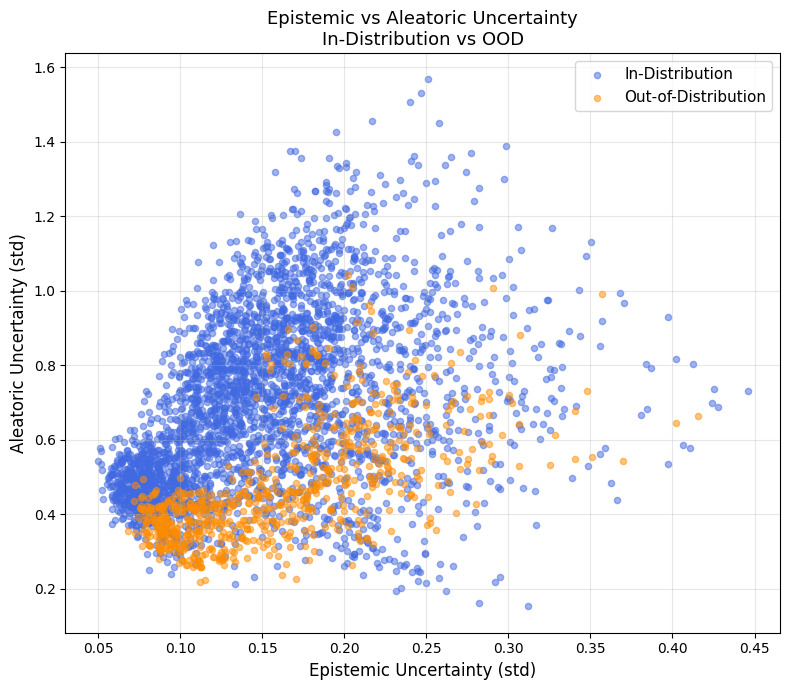

✓ Plot 1: Epistemic vs Aleatoric scatter


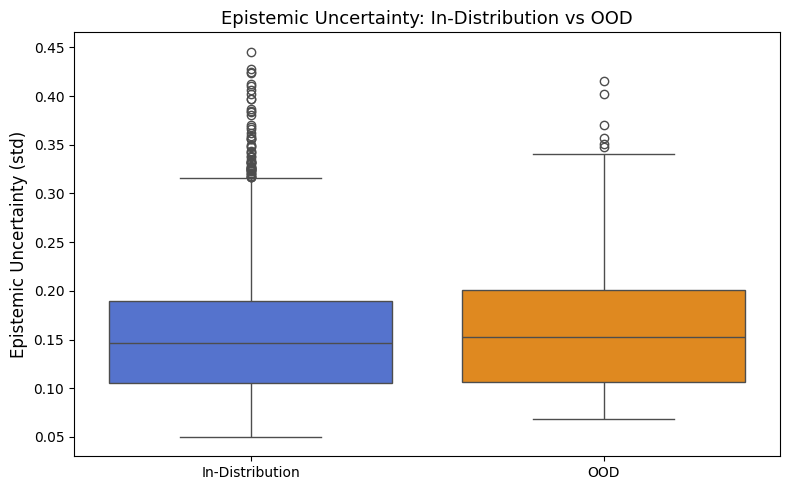

✓ Plot 2: Epistemic uncertainty comparison

Uncertainty Comparison:
In-Distribution (Test):
  Epistemic: 0.1540 ± 0.0622
  Aleatoric: 0.6964 ± 0.2324

Out-of-Distribution:
  Epistemic: 0.1595 ± 0.0609
  Aleatoric: 0.4682 ± 0.1484

💡 Key Insights:
   - OOD samples typically show HIGHER epistemic uncertainty
   - Aleatoric uncertainty reflects inherent data noise
   - Model is more uncertain about unfamiliar protein regions


In [38]:
# ============================================================
# COMPUTE UNCERTAINTIES FOR BOTH SPLITS
# ============================================================
print("🔄 Computing uncertainties for ID and OOD splits...\n")

mus_test, vars_test = mc_dropout_eval_hetero(model, test_X, n=100)
mus_ood, vars_ood = mc_dropout_eval_hetero(model, ood_X, n=100)

# Epistemic = variance of means across MC samples
epistemic_test = np.var(mus_test, axis=0, ddof=1)
epistemic_ood = np.var(mus_ood, axis=0, ddof=1)

# Aleatoric = mean of predicted variances
aleatoric_test = np.mean(vars_test, axis=0)
aleatoric_ood = np.mean(vars_ood, axis=0)

# Convert to standard deviations (more interpretable)
epistemic_test_std = np.sqrt(epistemic_test)
epistemic_ood_std = np.sqrt(epistemic_ood)
aleatoric_test_std = np.sqrt(aleatoric_test)
aleatoric_ood_std = np.sqrt(aleatoric_ood)

print("✓ Uncertainties computed for both splits")

# ============================================================
# PLOT 1: EPISTEMIC VS ALEATORIC SCATTER
# ============================================================
print("\n📊 Creating uncertainty comparison plots...\n")

plt.figure(figsize=(8, 7))

plt.scatter(
    epistemic_test_std, aleatoric_test_std,
    alpha=0.5, s=20, label="In-Distribution", color="royalblue"
)
plt.scatter(
    epistemic_ood_std, aleatoric_ood_std,
    alpha=0.5, s=20, label="Out-of-Distribution", color="darkorange"
)

plt.xlabel("Epistemic Uncertainty (std)", fontsize=12)
plt.ylabel("Aleatoric Uncertainty (std)", fontsize=12)
plt.title("Epistemic vs Aleatoric Uncertainty\nIn-Distribution vs OOD", fontsize=13)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Plot 1: Epistemic vs Aleatoric scatter")

# ============================================================
# PLOT 2: BOXPLOT COMPARISON
# ============================================================
# Prepare data for boxplot
in_df = pd.DataFrame({
    "epistemic": epistemic_test_std,
    "aleatoric": aleatoric_test_std,
})
in_df["split"] = "In-Distribution"

ood_df = pd.DataFrame({
    "epistemic": epistemic_ood_std,
    "aleatoric": aleatoric_ood_std,
})
ood_df["split"] = "OOD"

unc_df = pd.concat([in_df, ood_df], ignore_index=True)

plt.figure(figsize=(8, 5))
sns.boxplot(data=unc_df, x="split", y="epistemic", hue="split", palette=["royalblue", "darkorange"])
plt.title("Epistemic Uncertainty: In-Distribution vs OOD", fontsize=13)
plt.ylabel("Epistemic Uncertainty (std)", fontsize=12)
plt.xlabel("")
plt.tight_layout()
plt.show()

print("✓ Plot 2: Epistemic uncertainty comparison")

# ============================================================
# SUMMARY STATISTICS
# ============================================================
print("\n" + "="*60)
print("Uncertainty Comparison:")
print("="*60)
print(f"In-Distribution (Test):")
print(f"  Epistemic: {epistemic_test_std.mean():.4f} ± {epistemic_test_std.std():.4f}")
print(f"  Aleatoric: {aleatoric_test_std.mean():.4f} ± {aleatoric_test_std.std():.4f}")
print(f"\nOut-of-Distribution:")
print(f"  Epistemic: {epistemic_ood_std.mean():.4f} ± {epistemic_ood_std.std():.4f}")
print(f"  Aleatoric: {aleatoric_ood_std.mean():.4f} ± {aleatoric_ood_std.std():.4f}")
print("="*60)

print("\n💡 Key Insights:")
print("   - OOD samples typically show HIGHER epistemic uncertainty")
print("   - Aleatoric uncertainty reflects inherent data noise")
print("   - Model is more uncertain about unfamiliar protein regions")

### 9.4 Uncertainty vs Prediction Accuracy

We'll visualize how uncertainty correlates with prediction accuracy using colored scatter plots.

In [ ]:
# ============================================================
# PREPARE DATA FOR VISUALIZATION
# ============================================================
print("🎨 Creating uncertainty vs accuracy visualizations...\n")

# Re-compute predictions and uncertainties
mus_test, vars_test = mc_dropout_eval_hetero(model, test_X, n=100)
mus_ood, vars_ood = mc_dropout_eval_hetero(model, ood_X, n=100)

mu_mean_test = mus_test.mean(axis=0)
mu_mean_ood = mus_ood.mean(axis=0)

epistemic_test = np.var(mus_test, axis=0)
epistemic_ood = np.var(mus_ood, axis=0)

aleatoric_test = np.mean(vars_test, axis=0)
aleatoric_ood = np.mean(vars_ood, axis=0)

epistemic_test_std = np.sqrt(epistemic_test)
epistemic_ood_std = np.sqrt(epistemic_ood)

aleatoric_test_std = np.sqrt(aleatoric_test)
aleatoric_ood_std = np.sqrt(aleatoric_ood)

y_test_true = test_y.cpu().numpy().ravel()
y_ood_true = ood_y.cpu().numpy().ravel()

# ============================================================
# PLOTTING FUNCTION
# ============================================================
def _plot_uncertainty_pair(y_test_true, mu_mean_test, unc_test_std,
                           y_ood_true, mu_mean_ood, unc_ood_std,
                           unc_label="Epistemic"):
    """
    Create side-by-side plots showing true vs predicted values
    colored by uncertainty level.
    """
    # Compute shared color scale
    vmin = min(unc_test_std.min(), unc_ood_std.min())
    vmax = max(unc_test_std.max(), unc_ood_std.max())
    
    # Compute shared axis limits
    all_true = np.concatenate([y_test_true, y_ood_true])
    all_pred = np.concatenate([mu_mean_test, mu_mean_ood])
    lims = [min(all_true.min(), all_pred.min()), 
            max(all_true.max(), all_pred.max())]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    splits = [
        (y_test_true, mu_mean_test, unc_test_std, "In-Distribution"),
        (y_ood_true, mu_mean_ood, unc_ood_std, "Out-of-Distribution")
    ]

    sc = None
    for ax, (y_true, mu_mean, unc_std, title) in zip(axes, splits):
        sc = ax.scatter(
            y_true, mu_mean,
            c=unc_std,
            cmap="viridis",
            vmin=vmin, vmax=vmax,
            s=20, alpha=0.7, edgecolors="none"
        )
        # Perfect prediction line
        ax.plot(lims, lims, "r--", lw=2, label="Perfect prediction")
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_aspect("equal", adjustable="box")
        ax.set_title(title, fontsize=13)
        ax.set_xlabel("True Target", fontsize=11)
        ax.grid(alpha=0.3)
        ax.legend()

    axes[0].set_ylabel("Predicted Mean", fontsize=11)

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label(f"{unc_label} Uncertainty (std)", rotation=270, labelpad=20, fontsize=11)

    plt.suptitle(f"True vs Predicted (color = {unc_label} uncertainty)", fontsize=14, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])
    plt.show()

# ============================================================
# PLOT EPISTEMIC UNCERTAINTY
# ============================================================
print("Creating epistemic uncertainty visualization...")
_plot_uncertainty_pair(
    y_test_true, mu_mean_test, epistemic_test_std,
    y_ood_true, mu_mean_ood, epistemic_ood_std,
    unc_label="Epistemic"
)
print("✓ Epistemic uncertainty plot created")

# ============================================================
# PLOT ALEATORIC UNCERTAINTY
# ============================================================
print("\nCreating aleatoric uncertainty visualization...")
_plot_uncertainty_pair(
    y_test_true, mu_mean_test, aleatoric_test_std,
    y_ood_true, mu_mean_ood, aleatoric_ood_std,
    unc_label="Aleatoric"
)
print("✓ Aleatoric uncertainty plot created")

print("\n💡 Interpretation:")
print("   - Darker colors (yellow/green) = higher uncertainty")
print("   - Points far from diagonal = larger prediction errors")
print("   - OOD samples should show higher epistemic uncertainty (darker)")
print("   - Aleatoric uncertainty reflects irreducible noise")

---

## 📏 Step 10: Conformal Prediction

### 10.1 Introduction to Conformal Prediction

**Conformal Prediction** provides prediction intervals with **distribution-free coverage guarantees**. Unlike probabilistic methods, it makes no assumptions about the data distribution.

**Key Properties:**
- **Finite-sample guarantees**: Coverage holds for any sample size
- **Distribution-free**: No assumptions about data distribution
- **Post-hoc method**: Can be applied to any trained model

### 10.2 Training a Standard Regression MLP

First, we'll train a standard (non-heteroscedastic) MLP for regression.

In [ ]:
# ============================================================
# DEFINE STANDARD REGRESSION MLP
# ============================================================
class RegressionMLP(nn.Module):
    """
    Standard MLP for regression (single output).
    
    Parameters:
    -----------
    d_in : int
        Input dimension
    h : int
        Hidden layer size
    p : float
        Dropout probability
    """
    def __init__(self, d_in, h=256, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, h), 
            nn.ReLU(), 
            nn.Dropout(p),
            nn.Linear(h, h//2), 
            nn.ReLU(), 
            nn.Dropout(p),
            nn.Linear(h//2, 1)
        )
    
    def forward(self, x):
        return self.net(x)

# ============================================================
# TRAINING FUNCTION
# ============================================================
def train_plain_mlp(X_train, y_train, X_val, y_val, *, 
                     lr=1e-3, wd=1e-5, bs=1024, 
                     epochs=500, patience=25, p_drop=0.1):
    """
    Train a standard regression MLP with early stopping.
    
    Returns:
    --------
    RegressionMLP
        Trained model with best validation loss
    """
    d_in = X_train.shape[1]
    model = RegressionMLP(d_in, p=p_drop).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    crit = nn.MSELoss()

    best_val = float('inf')
    no_improve = 0
    
    print("🚀 Starting training...\n")
    
    for ep in range(epochs):
        # Training phase
        model.train()
        perm = torch.randperm(X_train.size(0), device=DEVICE)
        total = 0.0
        
        for i in range(0, X_train.size(0), bs):
            idx = perm[i:i+bs]
            xb, yb = X_train[idx], y_train[idx]
            opt.zero_grad(set_to_none=True)
            preds = model(xb)
            loss = crit(preds, yb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
        
        train_loss = total / X_train.size(0)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss = crit(model(X_val), y_val).item()

        # Logging
        if (ep + 1) % 10 == 0:
            print(f"Epoch {ep+1:03d}  train={train_loss:.4f}  val={val_loss:.4f}")

        # Early stopping
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "plain_mlp_best.pt")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"\n⏹️  Early stopping at epoch {ep+1}")
                break

    # Load best model
    model.load_state_dict(torch.load("plain_mlp_best.pt", map_location=DEVICE))
    model.eval()
    
    print(f"\n✓ Training complete! Best val loss: {best_val:.4f}")
    return model

# ============================================================
# PREDICTION HELPER FUNCTION
# ============================================================
@torch.no_grad()
def predict(model, X):
    """Get predictions from model."""
    model.eval()
    return model(X.to(DEVICE)).squeeze(1).cpu().numpy()

# ============================================================
# TRAIN MODEL
# ============================================================
print("🏗️  Training Standard Regression MLP")
print("="*60)

plain_model = train_plain_mlp(
    train_X, train_y, val_X, val_y, 
    lr=1e-4, wd=1e-6, p_drop=0.2
)

# ============================================================
# GET PREDICTIONS
# ============================================================
print("\n📊 Getting predictions on all splits...")

yhat_train = predict(plain_model, train_X)
yhat_val = predict(plain_model, val_X)
yhat_test = predict(plain_model, test_X)

y_train_np = train_y.cpu().numpy().ravel()
y_val_np = val_y.cpu().numpy().ravel()
y_test_np = test_y.cpu().numpy().ravel()

print("✓ Predictions complete")

# ============================================================
# COMPUTE METRICS
# ============================================================
def regression_metrics(y_true, y_pred, name="Set"):
    """Compute and print regression metrics."""
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    pear = pearsonr(y_true, y_pred)[0]
    spear = spearmanr(y_true, y_pred).correlation
    print(f"{name:<10s} | MSE={mse:.4f}  MAE={mae:.4f}  "
          f"Pearson={pear:.3f}  Spearman={spear:.3f}")
    return dict(mse=mse, mae=mae, pearson=pear, spearman=spear)

print("\n" + "="*60)
print("Regression Performance:")
print("="*60)

train_metrics = regression_metrics(y_train_np, yhat_train, "Train")
val_metrics = regression_metrics(y_val_np, yhat_val, "Val")
test_metrics = regression_metrics(y_test_np, yhat_test, "Test")

print("="*60)

# ============================================================
# PLOT PREDICTIONS VS TRUE VALUES
# ============================================================
lims = [
    min(y_test_np.min(), yhat_test.min()),
    max(y_test_np.max(), yhat_test.max())
]

plt.figure(figsize=(7, 7))
plt.scatter(y_test_np, yhat_test, alpha=0.6, s=20, edgecolors="none", color="royalblue")
plt.plot(lims, lims, 'r--', lw=2, label="Perfect prediction")
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("True Target", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.title("Predicted vs True (Test Set)", fontsize=13)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\n✓ Baseline model ready for conformal prediction")

### 10.3 Split Conformal Calibration & Intervals

We'll apply **Split Conformal Prediction** on top of a standard regression MLP to produce prediction intervals with finite-sample coverage guarantees.

Process overview:
1. Train a baseline regression model (already done)
2. Use the validation set as the calibration set to compute residual quantiles
3. Build intervals on test and OOD sets using the calibrated quantile
4. Evaluate empirical coverage and average interval width

In [ ]:
# ============================================================
# CONFORMAL CALIBRATION FUNCTION
# ============================================================
def conformal_calibrate(y_cal, yhat_cal, alpha):
    """
    Compute conformal quantile for split conformal prediction.
    
    Parameters:
    -----------
    y_cal : numpy.ndarray
        True values on calibration set
    yhat_cal : numpy.ndarray
        Predicted values on calibration set
    alpha : float
        Miscoverage level (e.g., 0.1 for 90% coverage)
        
    Returns:
    --------
    q : float
        Conformal quantile
    scores : numpy.ndarray
        Nonconformity scores (absolute residuals)
    """
    # Compute nonconformity scores (absolute residuals)
    scores = np.abs(y_cal - yhat_cal)
    n = scores.shape[0]
    
    # Finite-sample conservative correction
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q = np.quantile(scores, q_level, method='higher')
    
    return q, scores

# ============================================================
# INTERVAL CONSTRUCTION
# ============================================================
def conformal_intervals(yhat, q):
    """
    Construct prediction intervals using conformal quantile.
    
    Returns:
    --------
    lo, hi : tuple of numpy.ndarray
        Lower and upper bounds of prediction intervals
    """
    lo = yhat - q
    hi = yhat + q
    return lo, hi

# ============================================================
# COVERAGE METRICS
# ============================================================
def coverage_and_width(y_true, lo, hi):
    """
    Compute empirical coverage and average interval width.
    
    Returns:
    --------
    cov : float
        Empirical coverage (fraction of points within intervals)
    width : float
        Average interval width
    """
    cov = np.mean((y_true >= lo) & (y_true <= hi))
    width = np.mean(hi - lo)
    return cov, width

# ============================================================
# PREPARE DATA FOR CONFORMAL PREDICTION
# ============================================================
print("📏 Setting up conformal prediction...\n")

# Use validation set as calibration set
yhat_cal = predict(plain_model, val_X)
y_cal = val_y.cpu().numpy().ravel()

# Define confidence levels
alphas = [0.32, 0.10, 0.05]  # 68%, 90%, 95%
confidence_levels = {0.32: "68%", 0.10: "90%", 0.05: "95%"}

# Get predictions for test and OOD
yhat_test = predict(plain_model, test_X)
y_test_np = test_y.cpu().numpy().ravel()

yhat_ood = predict(plain_model, ood_X)
y_ood_np = ood_y.cpu().numpy().ravel()

print("✓ Data prepared for conformal prediction")

# ============================================================
# EVALUATE COVERAGE ACROSS CONFIDENCE LEVELS
# ============================================================
print("\n" + "="*60)
print("Conformal Prediction Coverage Analysis:")
print("="*60)

for alpha in alphas:
    conf_level = confidence_levels[alpha]
    
    # Calibrate on validation set
    q, cal_scores = conformal_calibrate(y_cal, yhat_cal, alpha)
    
    # Test set intervals and metrics
    lo_t, hi_t = conformal_intervals(yhat_test, q)
    cov_t, w_t = coverage_and_width(y_test_np, lo_t, hi_t)
    
    print(f"\n{conf_level} Confidence (α={alpha}):")
    print(f"  Quantile (q):        {q:.4f}")
    print(f"  [Test]   Coverage:   {cov_t:.3f}  |  Mean width: {w_t:.3f}")
    
    # OOD set intervals and metrics
    lo_o, hi_o = conformal_intervals(yhat_ood, q)
    cov_o, w_o = coverage_and_width(y_ood_np, lo_o, hi_o)
    
    print(f"  [OOD]    Coverage:   {cov_o:.3f}  |  Mean width: {w_o:.3f}")

print("="*60)

print("\n💡 Key Observations:")
print("   - Coverage should match or exceed target confidence level")
print("   - OOD samples may have similar coverage (distribution-free property)")
print("   - Wider intervals = more conservative predictions")

# ============================================================
# STORE RESULTS FOR VISUALIZATION
# ============================================================
# Choose one alpha to visualize (90% confidence)
alpha_vis = 0.10
q_vis, _ = conformal_calibrate(y_cal, yhat_cal, alpha_vis)

# Compute intervals for visualization
lo_t, hi_t = conformal_intervals(yhat_test, q_vis)
lo_o, hi_o = conformal_intervals(yhat_ood, q_vis)

print(f"\n✓ Prepared {confidence_levels[alpha_vis]} intervals for visualization")

### 10.4 Visualizing Prediction Intervals

We'll visualize conformal intervals on the Test (in-distribution) and OOD splits, highlighting covered vs. not covered points. Shorter intervals with correct coverage indicate better uncertainty estimates.

In [ ]:
# ============================================================
# PLOTTING FUNCTION FOR CONFORMAL INTERVALS
# ============================================================
def plot_conformal_intervals(y_true, yhat, lo, hi, title, powt=None, max_points=120):
    """
    Visualize conformal prediction intervals.
    
    Parameters:
    -----------
    y_true : numpy.ndarray
        True target values
    yhat : numpy.ndarray
        Predicted values
    lo, hi : numpy.ndarray
        Lower and upper bounds of intervals
    title : str
        Plot title
    powt : PowerTransformer, optional
        If provided, inverse transform to original scale
    max_points : int
        Maximum number of points to plot (for readability)
    """
    # Sort by true y and subsample for readability
    idx = np.argsort(y_true)
    y_true = y_true[idx]
    yhat = yhat[idx]
    lo = lo[idx]
    hi = hi[idx]
    step = max(1, len(y_true) // max_points)

    # Optional: transform back to original scale
    if powt is not None:
        y_true = powt.inverse_transform(y_true.reshape(-1, 1)).ravel()
        yhat = powt.inverse_transform(yhat.reshape(-1, 1)).ravel()
        lo = powt.inverse_transform(lo.reshape(-1, 1)).ravel()
        hi = powt.inverse_transform(hi.reshape(-1, 1)).ravel()

    # Subsample for visualization
    sel_idx = np.arange(0, len(y_true), step)

    # Create masks for covered vs uncovered points
    covered = (y_true >= lo) & (y_true <= hi)
    sel_mask = np.zeros_like(covered, dtype=bool)
    sel_mask[sel_idx] = True

    # Intersection masks
    mask_cov = covered & sel_mask
    mask_un = (~covered) & sel_mask

    # Error bars centered at yhat
    yerr = np.vstack([yhat - lo, hi - yhat])

    # Create plot
    plt.figure(figsize=(9, 6))
    
    # Covered points (blue)
    if mask_cov.any():
        plt.errorbar(
            y_true[mask_cov], yhat[mask_cov],
            yerr=yerr[:, mask_cov], fmt='o', ms=4, alpha=0.6,
            ecolor='tab:blue', capsize=2, elinewidth=1, label='Covered'
        )
    
    # Uncovered points (red)
    if mask_un.any():
        plt.errorbar(
            y_true[mask_un], yhat[mask_un],
            yerr=yerr[:, mask_un], fmt='o', ms=4, alpha=0.85,
            ecolor='tab:red', capsize=2, elinewidth=1, label='Not covered'
        )
    
    # Perfect prediction line
    lims = [
        min(y_true.min(), yhat.min(), lo.min()),
        max(y_true.max(), yhat.max(), hi.max())
    ]
    plt.plot(lims, lims, 'k--', lw=2, label='Perfect prediction', alpha=0.5)
    
    plt.xlim(lims)
    plt.ylim(lims)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("True Target", fontsize=12)
    plt.ylabel("Predicted ± Interval", fontsize=12)
    plt.title(title, fontsize=13)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# ============================================================
# VISUALIZE TEST SET INTERVALS
# ============================================================
print("\n📊 Creating conformal interval visualizations...\n")

plot_conformal_intervals(
    y_test_np, yhat_test, lo_t, hi_t,
    title=f"Conformal Intervals on Test Set (1-α={1-alpha_vis:.2f})"
)
print("✓ Test set visualization complete")

# ============================================================
# VISUALIZE OOD SET INTERVALS
# ============================================================
plot_conformal_intervals(
    y_ood_np, yhat_ood, lo_o, hi_o,
    title=f"Conformal Intervals on OOD Set (1-α={1-alpha_vis:.2f})"
)
print("✓ OOD set visualization complete")

# ============================================================
# OPTIONAL: PLOT IN ORIGINAL TEMPERATURE SCALE
# ============================================================
# Uncomment to visualize in original temperature units (°C)
# print("\n📊 Creating plots in original temperature scale...\n")
# 
# plot_conformal_intervals(
#     y_test_np, yhat_test, lo_t, hi_t, 
#     powt=powt,
#     title=f"Conformal Intervals on Test, Original Scale (°C) (1-α={1-alpha_vis:.2f})"
# )
# 
# plot_conformal_intervals(
#     y_ood_np, yhat_ood, lo_o, hi_o, 
#     powt=powt,
#     title=f"Conformal Intervals on OOD, Original Scale (°C) (1-α={1-alpha_vis:.2f})"
# )

print("\n💡 Interpretation:")
print("   - Blue points: True value falls within prediction interval")
print("   - Red points: True value outside interval (miscoverage)")
print("   - Error bars show interval width (yhat ± q)")
print("   - Ideally: High coverage, narrow intervals, points near diagonal")

print("\n✓ Conformal prediction analysis complete!")

---

## ✅ Step 11: Wrap-up and Next Steps

### What we covered
- Built a robust pipeline for Uncertainty Quantification in protein ML
- Used frozen ESM2 embeddings and trained an MLP classifier for EC prediction
- Assessed calibration and improved it via Temperature Scaling
- Modeled heteroscedastic regression with MC Dropout to separate epistemic and aleatoric uncertainty
- Applied Split Conformal Prediction to obtain intervals with finite-sample coverage guarantees

### Key takeaways
- Calibration matters: temperature scaling can significantly reduce ECE
- Epistemic vs Aleatoric: MC Dropout helps disentangle model and data uncertainty
- Conformal methods provide reliable coverage without strong distributional assumptions

### Try next
- Swap to a larger ESM2 model (e.g., esm2_t12_35M_UR50D) for richer embeddings
- Explore different binning or ECE variants (adaptive bins) for calibration analysis
- Use class-conditional temperature scaling or vector scaling for multi-class calibration
- Experiment with other UQ methods (deep ensembles, SWAG, Laplace)

### Reproducibility notes
- Random seeds are not fixed across all components; for exact reproducibility, set seeds in NumPy, PyTorch, and scikit-learn
- GPU precision set to float16 for ESM2 embeddings; adjust to float32 if needed for CPUs